# Twitter Sentiment Analysis using Spark & Hadoop

### Starting Hadoop Daemons

In [1]:
!start-all.sh

Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [Ahmads-MacBook-Air.local]
2024-04-26 20:14:42,509 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Starting resourcemanager
Starting nodemanagers


### Necessary Libraries

In [6]:
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, lower, explode
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer

### Spark Session

In [7]:
spark = SparkSession.builder \
    .appName("HadoopDataFetch") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://127.0.0.1:9000") \
    .getOrCreate()

24/04/26 20:49:30 WARN Utils: Your hostname, Ahmads-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.103 instead (on interface en0)
24/04/26 20:49:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/26 20:49:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Hadoop Cluster to Spark DataFrame

In [8]:
data_path = "/user/ahmadabdullah/twitter/sentiment.csv"

df = spark.read.format("csv").option("header", "true").option("encoding", "utf-8").load(data_path)

df.columns

['id',
 'candidate',
 'candidate_confidence',
 'relevant_yn',
 'relevant_yn_confidence',
 'sentiment',
 'sentiment_confidence',
 'subject_matter',
 'subject_matter_confidence',
 'candidate_gold',
 'name',
 'relevant_yn_gold',
 'retweet_count',
 'sentiment_gold',
 'subject_matter_gold',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_id',
 'tweet_location',
 'user_timezone']

In [9]:
columns_to_keep = ['sentiment', 'sentiment_confidence', 'text']

df = df[columns_to_keep]
df.show(10)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|              0.6578|RT @NancyLeeGrahn...|
| Positive|              0.6333|RT @ScottWalker: ...|
|  Neutral|              0.6629|RT @TJMShow: No m...|
| Positive|                 1.0|RT @RobGeorge: Th...|
| Positive|              0.7045|RT @DanScavino: #...|
| Positive|              0.6332|"RT @GregAbbott_T...|
| Negative|              0.6761|RT @warriorwoman9...|
|  Neutral|                 1.0|Going on #MSNBC L...|
| Negative|              0.6889|Deer in the headl...|
| Negative|              0.6778|RT @NancyOsborne1...|
+---------+--------------------+--------------------+
only showing top 10 rows



In [10]:
df = df.withColumn("sentiment_confidence", df["sentiment_confidence"].cast(DoubleType()))

In [11]:
df.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- sentiment_confidence: double (nullable = true)
 |-- text: string (nullable = true)



In [12]:
df.count()

16032

### Dropping Nulls, Retweets & Duplicate

In [13]:
df = df.na.drop()
df = df.dropDuplicates()

In [27]:
df = df.filter(~df['text'].startswith('RT'))
df = df.filter(~df['text'].startswith('"RT'))
df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|              0.3511|@Bipartisanism We...|
| Negative|              0.6841|"After #GOPDebate...|
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|              0.6517|"@Krauthammer: ""...|
| Negative|                 1.0|"""@RubinReport: ...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [28]:
df.count()

6158

### Plotting the Univariate Distribution of Sentiments

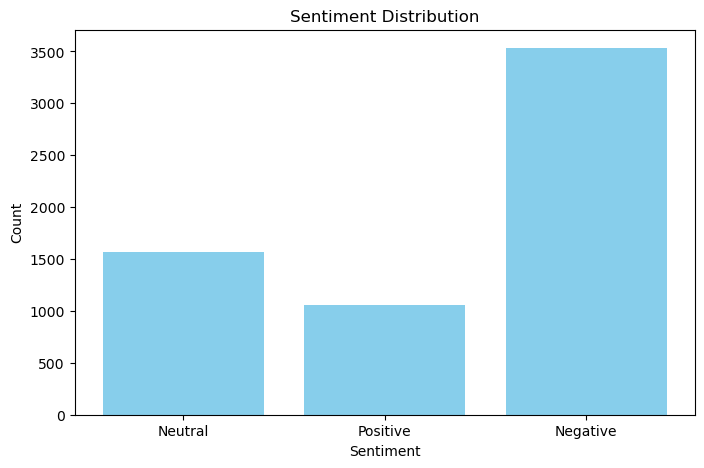

In [29]:
sentiment_counts = df.groupBy('sentiment').count()
sentiment_counts_pd = sentiment_counts.toPandas()
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts_pd['sentiment'], sentiment_counts_pd['count'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

### Text Cleaning

In [30]:
characters = "[^\w\s]"

df = df.withColumn("text", regexp_replace(col("text"), characters, ""))

df = df.withColumn("text", lower(col("text")))

df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|              0.3511|bipartisanism wel...|
| Negative|              0.6841|after gopdebate t...|
|  Neutral|                 1.0|gopdebate constan...|
| Negative|              0.6517|krauthammer the r...|
| Negative|                 1.0|rubinreport final...|
+---------+--------------------+--------------------+
only showing top 5 rows



### Tokenization

In [31]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

cv = CountVectorizer(inputCol="words", outputCol="features")
model = cv.fit(df)
df = model.transform(df)

df.select("text", "features", "sentiment").show()

+--------------------+--------------------+---------+
|                text|            features|sentiment|
+--------------------+--------------------+---------+
|bipartisanism wel...|(12278,[0,1,4,33,...|  Neutral|
|after gopdebate t...|(12278,[0,1,79,12...| Negative|
|gopdebate constan...|(12278,[1,2,5,15,...|  Neutral|
|krauthammer the r...|(12278,[0,1,6,7,1...| Negative|
|rubinreport final...|(12278,[1,13,18,3...| Negative|
|gopdebate johnkas...|(12278,[1,69,162,...| Negative|
|steelhamster here...|(12278,[1,5,35,40...| Negative|
|fox news was the ...|(12278,[0,1,2,4,6...|  Neutral|
|fact checking is ...|(12278,[0,1,6,7,2...| Negative|
|gopdebate got you...|(12278,[1,10,14,4...| Negative|
|scientific studie...|(12278,[1,9,29,37...| Negative|
|realdonaldtrump i...|(12278,[0,1,2,5,6...| Negative|
|that foxnews is s...|(12278,[0,1,2,7,1...| Negative|
|megyn kelly was a...|(12278,[0,1,5,10,...| Negative|
|clear winner from...|(12278,[1,4,17,35...| Positive|
|pretty sure i was...|(12278

In [14]:
positive_texts = df.filter(df['sentiment'] == 'positive').select("text").rdd.flatMap(lambda x: x).collect()
negative_texts = df.filter(df['sentiment'] == 'negative').select("text").rdd.flatMap(lambda x: x).collect()
neutral_texts = df.filter(df['sentiment'] == 'neutral').select("text").rdd.flatMap(lambda x: x).collect()

positive_text = " ".join(positive_texts)
negative_text = " ".join(negative_texts)
neutral_text = " ".join(neutral_texts)

positive_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(negative_text)
neutral_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(neutral_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Sentiment Word Cloud')
plt.show()

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Sentiment Word Cloud')
plt.show()

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(neutral_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Neutral Sentiment Word Cloud')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [224]:
spark.stop()

In [225]:
!stop-all.sh

Stopping namenodes on [localhost]
Stopping datanodes
Stopping secondary namenodes [Ahmads-MacBook-Air.local]
2024-04-26 18:15:43,161 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Stopping nodemanagers
localhost: WARNING: nodemanager did not stop gracefully after 5 seconds: Trying to kill with kill -9
Stopping resourcemanager
